# Part 2 - Model building and selection

This notebook is part 2 of the capstone project from the [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow). The main goal here is to compare different models to predict revenue, given the [data](https://github.com/aavail/ai-workflow-capstone), and select one to be put into production.

Author: Rafael da Ponte Barbosa

In [3]:
import pandas as pd
import numpy as np
import os
#import re
#import datetime
import matplotlib.pyplot as plt

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data
from application.utils.processing import convert_to_ts

from application.utils.plot import ts_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_dir = os.path.join("data","cs-train")
df = fetch_data(data_dir)
df_ts = convert_to_ts(df)

In [5]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [6]:
df_ts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-28,3223,166,1345,15047,2017-11,14450.54
1,2017-11-29,3277,133,1397,14159,2017-11,13411.96
2,2017-11-30,3002,150,1335,15766,2017-11,13290.25
3,2017-12-01,2559,107,1256,12524,2017-12,9687.28
4,2017-12-02,402,32,287,3313,2017-12,1443.26


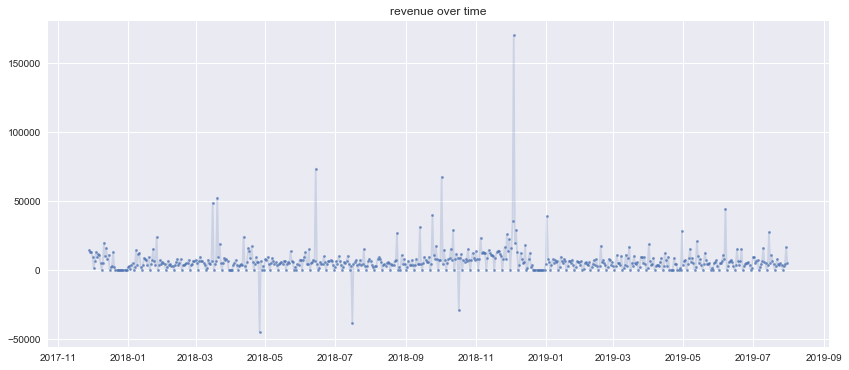

In [8]:
ts_plot(df_ts.date,df_ts["revenue"],figx=14,figy=6, title="revenue over time")